## Preliminaries

In [1]:
from skfem import *
from skfem.models.poisson import unit_load
import numpy as np
from skfem.visuals.matplotlib import *
# from skfem.utils import solver_iter_krylov
from skfem.helpers import dd, ddot
from scipy.sparse.linalg import LinearOperator, minres

## Morley

Problem:
$$ \Delta^2 u = 1 \  in \ \Omega$$ 
$$  u = \frac{\partial u}{\partial \boldsymbol{n}} = 0 \ on \ \Gamma$$
$$ \int_\Omega \boldsymbol{K}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V $$

### Standard solution

Wall time: 93.5 ms


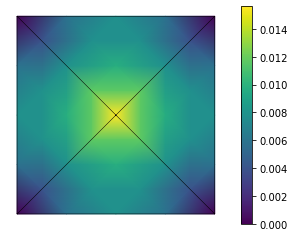

In [2]:
%%time
m = MeshTri.init_symmetric() # 整个区域为正方形 
# m = MeshTri.init_refdom() # 整个区域为三角形
m.refine(0)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    # ep = 1
    return ddot(dd(u), dd(v))


K = asm(bilinf, ib)
f = asm(unit_load, ib)

dofs = ib.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u'],
                    dofs['left'].facet['u_n'], 
                    dofs['right'].facet['u_n'], 
                    dofs['top'].facet['u_n'], 
                    dofs['buttom'].facet['u_n']
                   ))


x = solve(*condense(K, f, D=D)) # condense 连接

ax = draw(m)

plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)

In [3]:
ib.nodal_dofs # nodes

array([[0, 1, 2, 3, 4]], dtype=int64)

In [4]:
ib.facet_dofs # facets

array([[ 5,  6,  7,  8,  9, 10, 11, 12]], dtype=int64)

In [5]:
x

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.56250000e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.67361738e-18,  0.00000000e+00,  0.00000000e+00,
       -6.07153217e-18])

In [6]:
len(x)

13

In [7]:
m.p # position of nodes

array([[0. , 1. , 1. , 0. , 0.5],
       [0. , 0. , 1. , 1. , 0.5]])

In [8]:
m.facets

array([[0, 0, 0, 1, 1, 2, 2, 3],
       [1, 3, 4, 2, 4, 3, 4, 4]], dtype=int64)

### interior nodes

Wall time: 82.1 ms


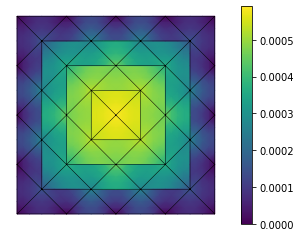

In [9]:
%%time
m = MeshTri.init_symmetric()  # 整个区域为正方形
# m = MeshTri.init_refdom() # 整个区域为三角形
m.refine(2)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    # ep = 1
    return ddot(dd(u), dd(v))


K = asm(bilinf, ib)
f = asm(unit_load, ib)

x = solve(*condense(K, f, I=m.interior_nodes()))

ax = draw(m)
plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)

In [10]:
x[m.facets_satisfying(lambda x: x[0] == 1)]

array([0.00059086, 0.        , 0.00026722, 0.00026722])

## PoissonP1
two ways to set $0$ boundary conditions

$$ -\Delta u=1 \ in \  \Omega$$
$$ u = 0 \ on \ \Gamma$$

### Solve with `I`

Wall time: 40.9 ms


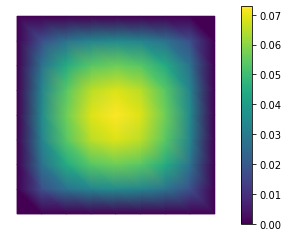

In [11]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x1 = solve(*condense(K, f, I=m.interior_nodes()))

plot(m, x1, shading='gouraud', colorbar=True)

Wall time: 59.3 ms


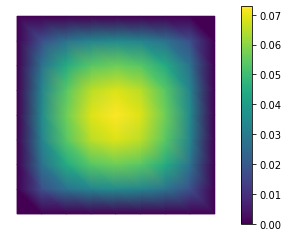

In [12]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

K = asm(laplace, basis)
f = asm(unit_load, basis)

x1 = solve(*condense(K, f, I=m.interior_nodes()))

plot(m, x1, shading='gouraud', colorbar=True)

### Solve with `D`

Wall time: 41.5 ms


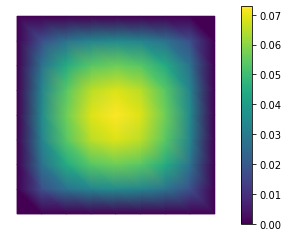

In [39]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

dofs = basis.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u']
                   ))


x2 = solve(*condense(A, b, D=D)) # condense 连接

# x = solve(*condense(A, b, I=m.interior_nodes()))

plot(m, x2, shading='gouraud', colorbar=True)

Wall time: 51.2 ms


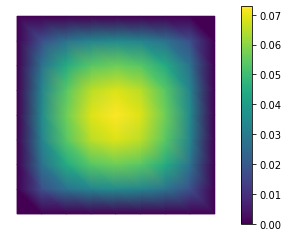

In [41]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

dofs = basis.find_dofs({
    'left': m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top': m.facets_satisfying(lambda x: x[1] == 1),
    'buttom': m.facets_satisfying(lambda x: x[1] == 0)
})

D = np.concatenate((dofs['left'].nodal['u'], 
                    dofs['right'].nodal['u'],
                    dofs['top'].nodal['u'], 
                    dofs['buttom'].nodal['u']
                   ))


x2 = solve(*condense(A, b, D=D)) # condense 连接

# x = solve(*condense(A, b, I=m.interior_nodes()))

plot(m, x2, shading='gouraud', colorbar=True)

### Try P2

Wall time: 46.9 ms


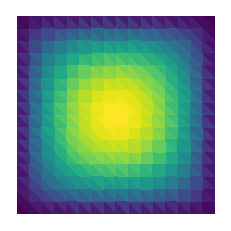

In [45]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP2()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, D=basis.find_dofs()))

plot(basis, x)

### Try P0

In [55]:
%%time
from skfem.visuals.matplotlib import plot, savefig
from sys import argv
from os.path import splitext
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(3)

e = ElementTriP0()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, D=basis.find_dofs()))

# plot(basis, x)

Wall time: 7.06 ms


C:\Users\ASUS\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [56]:
x

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### Compare the results

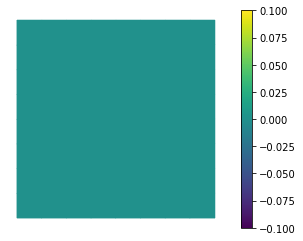

In [14]:
plot(m, x1-x2, shading='gouraud', colorbar=True)

## Mesh Structure
a mess

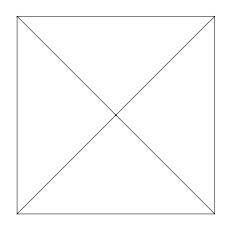

In [15]:
m = MeshTri.init_symmetric()
m.refine(0)

draw(m)

### Boundary nodes

In [16]:
m.boundary_nodes()+1

array([1, 2, 3, 4], dtype=int64)

### Interior nodes

In [17]:
m.interior_nodes()+1

array([5])

### Coordinates

In [18]:
m.p

array([[0. , 1. , 1. , 0. , 0.5],
       [0. , 0. , 1. , 1. , 0.5]])

## Boundary conditions
`condense()` 
> using `*` to unzip the parameters in `solve(*condense())`

- use $D$ to represent indices to dismiss
- use $I$ to represent indices to keep
> the eliminated dofs will be set to zero by dafault and can be determined by setting $x$

In [19]:
condense(A, b, D=m.boundary_nodes())

(<77x77 sparse matrix of type '<class 'numpy.float64'>'
 	with 349 stored elements in Compressed Sparse Row format>,
 array([0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125, 0.0078125,
        0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125, 0.015625 ,
        0.0078125, 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.0078125, 0.0078125, 0.0078125,
        0.015625 , 0.0078125, 0.0078125, 0.015625 , 0.0078125, 0.0078125,
        0.0078125, 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.0078125,
        0.0078125, 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.0078125, 0.0078125, 0.015625 ,
        0.015625 , 0.0078125, 0.0078125, 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 ,
        0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.015625 , 0.0156

## two ways to assemble basis

In [20]:
from skfem import *
from skfem.models.poisson import laplace, unit_load
m = MeshTri()
m.refine(2)
basis = InteriorBasis(m, ElementTriP1())
A = laplace.assemble(basis)

In [21]:
b = unit_load.assemble(basis)

In [22]:
b

array([0.01041667, 0.02083333, 0.02083333, 0.01041667, 0.03125   ,
       0.03125   , 0.0625    , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.0625    , 0.03125   , 0.03125   ,
       0.0625    , 0.03125   , 0.03125   , 0.03125   , 0.0625    ,
       0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ])

In [23]:
b = asm(unit_load, basis)

In [24]:
b

array([0.01041667, 0.02083333, 0.02083333, 0.01041667, 0.03125   ,
       0.03125   , 0.0625    , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.0625    , 0.03125   , 0.03125   ,
       0.0625    , 0.03125   , 0.03125   , 0.03125   , 0.0625    ,
       0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ])

## Supported elements

In [25]:
import skfem.element
dir(skfem.element)

['DiscreteField',
 'Element',
 'ElementComposite',
 'ElementH1',
 'ElementHcurl',
 'ElementHdiv',
 'ElementHex1',
 'ElementHex2',
 'ElementHexS2',
 'ElementLineHermite',
 'ElementLineMini',
 'ElementLineP1',
 'ElementLineP2',
 'ElementLinePp',
 'ElementQuad0',
 'ElementQuad1',
 'ElementQuad2',
 'ElementQuadBFS',
 'ElementQuadDG',
 'ElementQuadP',
 'ElementQuadS2',
 'ElementTetMini',
 'ElementTetN0',
 'ElementTetP0',
 'ElementTetP1',
 'ElementTetP2',
 'ElementTetRT0',
 'ElementTriArgyris',
 'ElementTriDG',
 'ElementTriMini',
 'ElementTriMorley',
 'ElementTriP0',
 'ElementTriP1',
 'ElementTriP2',
 'ElementTriRT0',
 'ElementVectorH1',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'discrete_field',
 'element',
 'element_composite',
 'element_global',
 'element_h1',
 'element_hcurl',
 'element_hdiv',
 'element_hex',
 'element_line',
 'element_quad',
 'element_tet',
 'element_tri',
 'element_vector_

In [ ]:
# ### adding facet

# m = MeshTri.init_symmetric()
# m.refine(2)

# e = ElementTriMorley()
# ib = InteriorBasis(m, e)


# @BilinearForm
# def bilinf(u, v, w):
#     from skfem.helpers import dd, ddot, trace, eye
#     d = 0.1
#     E = 200e9
#     nu = 0.3

#     def C(T):
#         return E / (1 + nu) * (T + nu / (1 - nu) * eye(trace(T), 2))

#     return d**3 / 12.0 * ddot(C(dd(u)), dd(v))


# K = asm(bilinf, ib)
# f = 1e6 * asm(unit_load, ib)


# dofs = ib.find_dofs({
#     'left':  m.facets_satisfying(lambda x: x[0] == 0),
#     'right': m.facets_satisfying(lambda x: x[0] == 1),
#     'top':   m.facets_satisfying(lambda x: x[1] == 1),
#     'buttom': m.facets_satisfying(lambda x: x[1] == 0)
# })

# D = np.concatenate((
#     dofs['left'].nodal['u'],
#     dofs['left'].facet['u_n'],
#     dofs['right'].facet['u_n'],
#     dofs['top'].facet['u_n'],
#     dofs['right'].nodal['u'],
#     dofs['top'].nodal['u'],
#     dofs['buttom'].nodal['u']
# ))

# x = solve(*condense(K, f, D=D))

# ax = draw(m)
# plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)